# Presentation in which we do some predictive modeling with _____ model/algorithm or whatever

STEPS
- Introduce the dataset
- Do basic EDA (distributions, make some cool graphs, maybe check for diff in means for teh periods, CLUSTERING!)
- Develop Predictive Model (try a few?)
- Defend our methods

In [66]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats as sms
import xgboost as xgb


## Describing The Dataset

Tachycardia is an abnormally rapid heart rate (above 100 bpm at rest). Our dataset contains personal health and lifestyle measurements, such as age, if they have diabetes, and blood pressure from 1734 people at 3 distinct periods of their lives (each 6 years apart), as well as each person's heart rates at time of measurement. We want to better understand the relationship between all these health and lifestyle characteristics, as well as which factors might contribute to if a person has tachycardia.

Variables: 
- RANDID: unique identifier for each person
- SEX: M = 1, F = 2
- TOTCHOL: total cholesterol (mg/dL)
- AGE: age (years)
- SYSBP: systolic blood pressure (mmHg)
- DIABP: diastolic blood pressure (mmHg)
- CURSMOKE: current smoker (1 = yes, 0 = no)
- BMI: body mass index (kg/m^2)
- DIABETES: diabetes (1 = yes, 0 = no)
- BPMEDS: blood pressure medication (1 = yes, 0 = no)
- HEARTRATE: heart rate (beats per minute)
- GLUCOSE: glucose (mg/dL)
- PERIOD: period of measurement (1 = baseline, 2 = 6 years later, 3 = 12 years later)

Target Variable: Heart Rate


In [34]:
# read in the data from ./data/presentation_nov_3.txt
df = pd.read_csv('data/presentation_nov_3/Tachycardia.txt', sep=' ')
df.head(6)

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,BMI,DIABETES,BPMEDS,HEARTRATE,GLUCOSE,PERIOD
0,6238,2,250,46,121.0,81.0,0,28.73,0,0,95,76,1
1,6238,2,260,52,105.0,69.5,0,29.43,0,0,80,86,2
2,6238,2,237,58,108.0,66.0,0,28.50,0,0,80,71,3
3,11263,2,228,43,180.0,110.0,0,30.30,0,0,77,99,1
4,11263,2,230,49,177.0,102.0,0,31.36,0,1,120,86,2
5,11263,2,220,55,180.0,106.0,0,31.17,1,1,86,81,3


In [27]:
# check for missing values
df.isnull().sum()

RANDID       0
SEX          0
TOTCHOL      0
AGE          0
SYSBP        0
DIABP        0
CURSMOKE     0
BMI          0
DIABETES     0
BPMEDS       0
HEARTRATE    0
GLUCOSE      0
PERIOD       0
dtype: int64

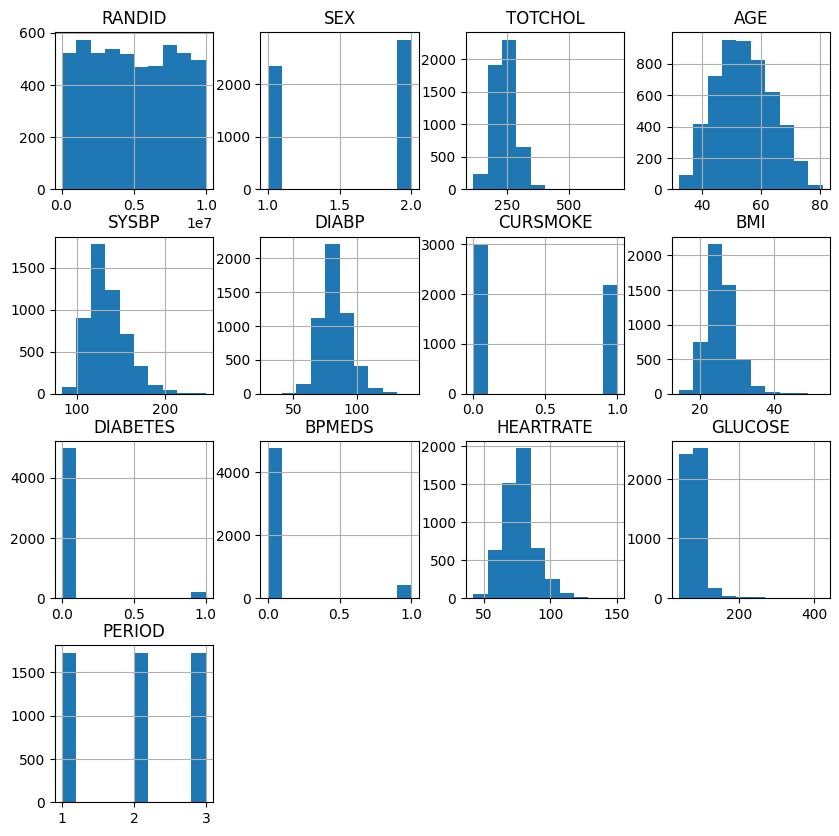

1728.6666666666667

In [28]:
#check distribution of each column excluding RANDID
df.hist(figsize=(10,10))
plt.show()

len(df) / 3

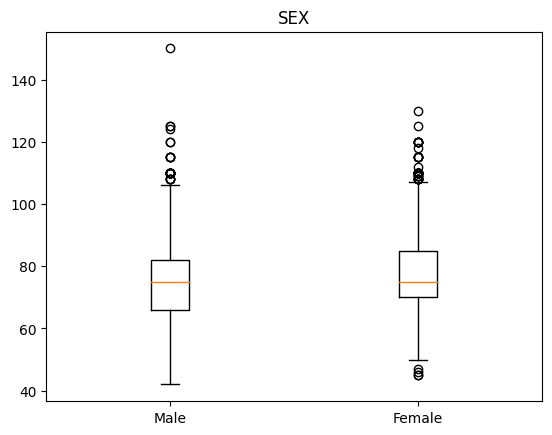

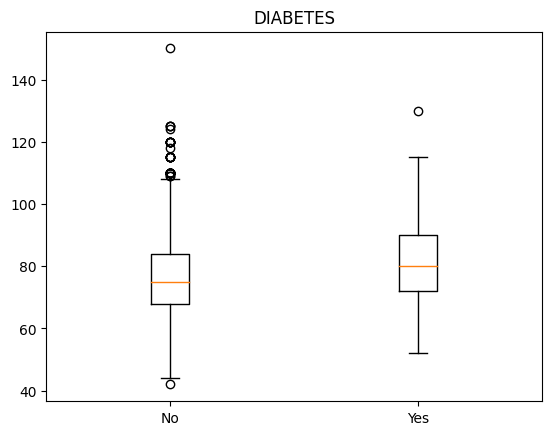

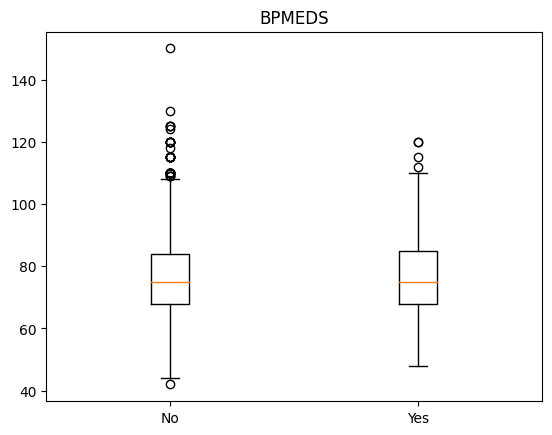

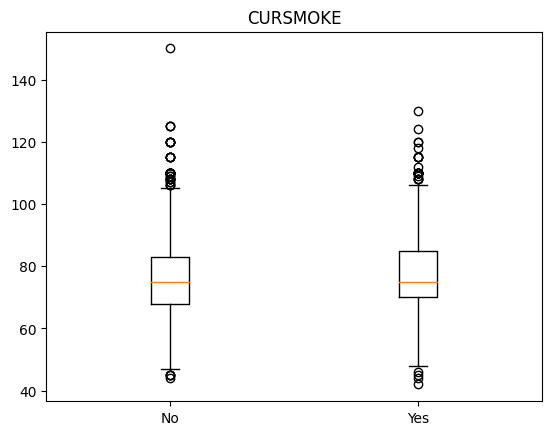

In [53]:
#boxplot of each column excluding RANDID 
boxplot_df = df.drop(['RANDID','PERIOD'], axis=1)
#boxplot of heart rate against categorical columns
for column in ['SEX', 'DIABETES', 'BPMEDS', 'CURSMOKE']:
    split_df = boxplot_df.groupby(column)
    #label by the groupby value
    labels = split_df.groups.keys()
    new_labels = []
    if column == 'SEX':
        #change labels 1 -> Male, 2 -> Female
        for i, label in enumerate(labels):
            if label == 1:
                new_labels.append('Male')
            else:
                new_labels.append('Female')

    if column == 'DIABETES':
        #change labels 0 -> NO, 1 -> Yes
        for i, label in enumerate(labels):
            if label == 0:
                new_labels.append('No')
            else:
                new_labels.append('Yes')
    if column == 'BPMEDS':
        #change labels 1 -> Yes, 0 -> No
        for i, label in enumerate(labels):
            if label == 0:
                new_labels.append('No')
            else:
                new_labels.append('Yes')
    if column == 'CURSMOKE':
        #change labels 1 -> Yes, 0 -> No
        for i, label in enumerate(labels):
            if label == 0:
                new_labels.append('No')
            else:
                new_labels.append('Yes')
    #get the values for each group
    values = [split_df.get_group(x)['HEARTRATE'].values for x in labels]
    #plot the boxplot
    plt.boxplot(values, labels=new_labels)
    plt.title(column)
    plt.show()

    # split_df.boxplot(column='HEARTRATE', figsize=(5,5))
    # plt.figure()

In [29]:
# do some EDA
df.describe()


,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,BMI,DIABETES,BPMEDS,HEARTRATE,GLUCOSE,PERIOD
count,5.186000e+03,5186.000000,5186.000000,5186.000000,5186.000000,5186.000000,5186.000000,5186.000000,5186.000000,5186.000000,5186.000000,5186.000000,5186.000000
mean,4.923633e+06,1.548785,241.363286,54.125916,134.354223,82.456325,0.420363,25.694449,0.038565,0.081180,76.404165,83.750868,2.000193
std,2.887600e+06,0.497662,45.684325,9.631021,21.428434,11.264197,0.493665,3.806190,0.192575,0.273138,12.065291,23.148733,0.816536
min,3.468900e+04,1.000000,113.000000,32.000000,83.500000,30.000000,0.000000,14.430000,0.000000,0.000000,42.000000,40.000000,1.000000
25%,2.376358e+06,1.000000,210.000000,47.000000,119.000000,75.000000,0.000000,23.100000,0.000000,0.000000,68.000000,72.000000,1.000000
50%,4.762162e+06,2.000000,239.000000,54.000000,131.000000,81.750000,0.000000,25.340000,0.000000,0.000000,75.000000,80.000000,2.000000
75%,7.432416e+06,2.000000,268.000000,61.000000,147.000000,89.000000,1.000000,27.820000,0.000000,0.000000,84.000000,89.000000,3.000000
max,9.969773e+06,2.000000,696.000000,81.000000,246.000000,142.500000,1.000000,52.940000,1.000000,1.000000,150.000000,423.000000,3.000000


In [30]:
#calculate collinearity 
#remove RANDID column 
df_cov_corr = df.drop(['RANDID', 'PERIOD'], axis=1)
corr = df_cov_corr.corr()
corr.style.background_gradient(cmap='coolwarm')


,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,BMI,DIABETES,BPMEDS,HEARTRATE,GLUCOSE
SEX,1.000000,0.134592,0.041029,0.033555,-0.070674,-0.132946,-0.120678,-0.033722,0.090751,0.101042,-0.015083
TOTCHOL,0.134592,1.000000,0.187373,0.169434,0.137044,-0.066994,0.073906,0.003099,0.068951,0.091566,-0.016968
AGE,0.041029,0.187373,1.000000,0.376899,0.045796,-0.267422,0.061976,0.135892,0.191060,0.035359,0.158370
SYSBP,0.033555,0.169434,0.376899,1.000000,0.712613,-0.168675,0.242637,0.139143,0.341953,0.166137,0.140973
DIABP,-0.070674,0.137044,0.045796,0.712613,1.000000,-0.099291,0.322457,0.040208,0.231586,0.168756,0.021190
CURSMOKE,-0.132946,-0.066994,-0.267422,-0.168675,-0.099291,1.000000,-0.151231,-0.032606,-0.082920,0.052518,-0.058308
BMI,-0.120678,0.073906,0.061976,0.242637,0.322457,-0.151231,1.000000,0.066449,0.071352,0.017936,0.079839
DIABETES,-0.033722,0.003099,0.135892,0.139143,0.040208,-0.032606,0.066449,1.000000,0.068801,0.084930,0.470442
BPMEDS,0.090751,0.068951,0.191060,0.341953,0.231586,-0.082920,0.071352,0.068801,1.000000,0.019362,0.048557
HEARTRATE,0.101042,0.091566,0.035359,0.166137,0.168756,0.052518,0.017936,0.084930,0.019362,1.000000,0.150267


In [31]:
#calculate covariance
cov = df_cov_corr.cov()
cov.style.background_gradient(cmap='coolwarm')


,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,BMI,DIABETES,BPMEDS,HEARTRATE,GLUCOSE
SEX,0.247668,3.059998,0.196653,0.357836,-0.396181,-0.032662,-0.228588,-0.003232,0.012336,0.606701,-0.173765
TOTCHOL,3.059998,2087.057583,82.441615,165.866373,70.522620,-1.510890,12.850954,0.027260,0.860377,50.470888,-17.944385
AGE,0.196653,82.441615,92.756563,77.783547,4.968181,-1.271455,2.271879,0.252038,0.502602,4.108791,35.307943
SYSBP,0.357836,165.866373,77.783547,459.177781,172.006361,-1.784321,19.789603,0.574186,2.001422,42.953143,69.928285
DIABP,-0.396181,70.522620,4.968181,172.006361,126.882133,-0.552129,13.824921,0.087220,0.712514,22.934917,5.525375
CURSMOKE,-0.032662,-1.510890,-1.271455,-1.784321,-0.552129,0.243705,-0.284160,-0.003100,-0.011181,0.312810,-0.666324
BMI,-0.228588,12.850954,2.271879,19.789603,13.824921,-0.284160,14.487083,0.048706,0.074179,0.823669,7.034518
DIABETES,-0.003232,0.027260,0.252038,0.574186,0.087220,-0.003100,0.048706,0.037085,0.003619,0.197332,2.097170
BPMEDS,0.012336,0.860377,0.502602,2.001422,0.712514,-0.011181,0.074179,0.003619,0.074604,0.063808,0.307017
HEARTRATE,0.606701,50.470888,4.108791,42.953143,22.934917,0.312810,0.823669,0.197332,0.063808,145.571238,41.968984


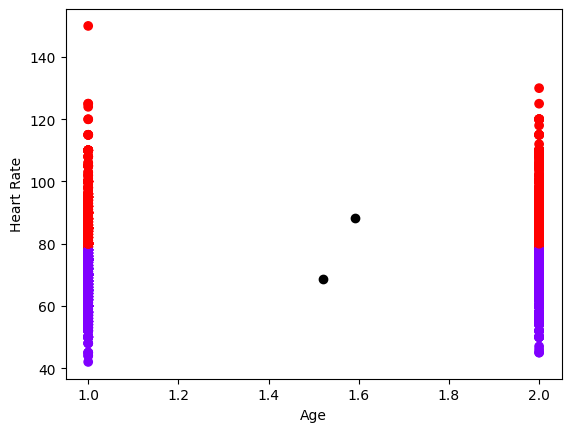

In [65]:
# # use kmeans to cluster the data????
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.metrics import silhouette_score

# #remove just use age and heart rate
# df_kmeans = df[['SEX', 'HEARTRATE']]
# #scale the data
# # scaler = StandardScaler()
# # scaled_df = scaler.fit_transform(df_kmeans)

# #use elbow method to find optimal number of clusters
# # sse = []
# # for k in range(1, 10):
# #     kmeans = KMeans(n_clusters=k)
# #     kmeans.fit(scaled_df)
# #     sse.append(kmeans.inertia_)
# # plt.plot(range(1, 10), sse)
# # plt.xlabel('Number of clusters')
# # plt.ylabel('SSE')
# # plt.show()

# kmeans = KMeans(n_clusters=2)
# kmeans.fit(df_kmeans)
# labels = kmeans.labels_
# centroids = kmeans.cluster_centers_
# #plot 
# plt.scatter(df_kmeans['SEX'], df_kmeans['HEARTRATE'], c=labels, cmap='rainbow')
# plt.scatter(centroids[:,0], centroids[:,1], color='black')
# plt.xlabel('Age')
# plt.ylabel('Heart Rate')
# plt.show()



# Creating predictive models
1. XGBoost
2. 

In [70]:
#XGBOOST to predict HEARTRATE

#remove RANDID column
df_xgb = df.drop(['RANDID', 'PERIOD'], axis=1)
#split into train and test
from sklearn.model_selection import train_test_split
X = df_xgb.drop('HEARTRATE', axis=1)
y = df_xgb['HEARTRATE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#fit the model

from xgboost import XGBRegressor
#do a grid search to find optimal parameters
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 200, 300, 400, 500]
}

xgb_model = XGBRegressor()

# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)
# {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

xgb_model = XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=100, booster='gbtree')
xgb_model.fit(X_train, y_train)


xgb = XGBRegressor()

xgb.fit(X_train, y_train)

#predict
y_pred = xgb.predict(X_test)

#calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %f' % (rmse))

#calculate R^2
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print('R^2: %f' % (r2))


RMSE: 12.729616
R^2: -0.038462
